# Tuning the ARIMA Model
Week 9 | Lesson 4.1


<a name="eda"></a>
## Codealong: European Retail Trade Data EDA (15 mins)

Let's take a look at this data set, which displays European retail trade data reported quarterly from 1996-2011. To start, let's load the data into pandas and build a basic plot.

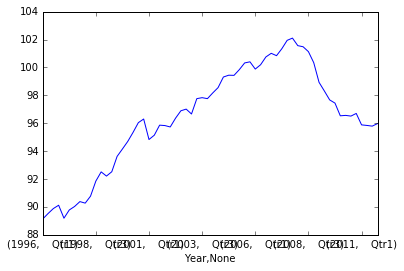

In [1]:
import pandas as pd
%matplotlib inline

df = pd.read_csv('../assets/data/euretail.csv')
df = df.set_index(['Year'])
df.stack().plot()


Off the bat, what can we tell about our data? We see that our data is Non-Stationary, and there are some apparent seasonal patterns. Let's take a Seasonal Difference to see what effect that has. What should our value for _m_ be in this case?

>Answer: Best to start with 4, because our samples are taken quarterly

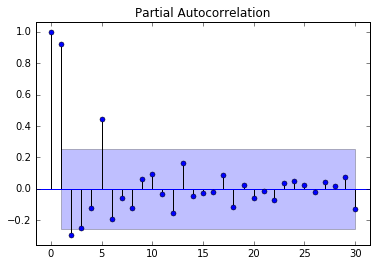

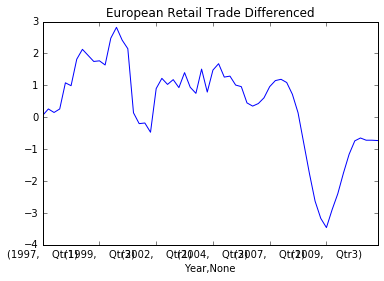

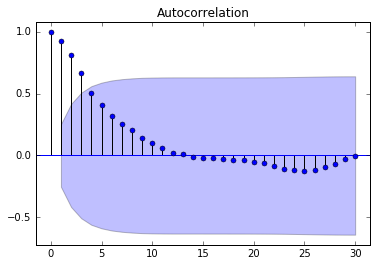

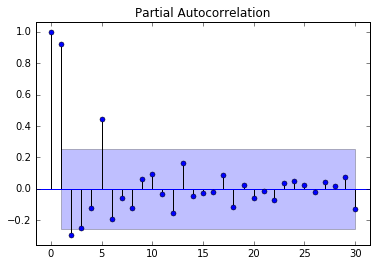

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff0 = df.stack().diff(periods=4)[4:]
diff0.plot(title='European Retail Trade Differenced')
plot_acf(diff0, lags=30)
plot_pacf(diff0, lags=30)


What does this tell us, and what should we do next?

> Answer: The data is still non-stationary, so let's take an additional first order difference.

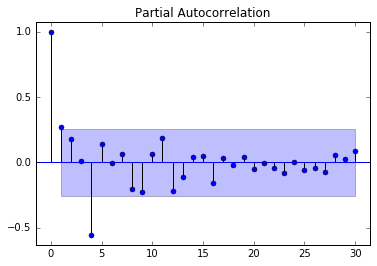

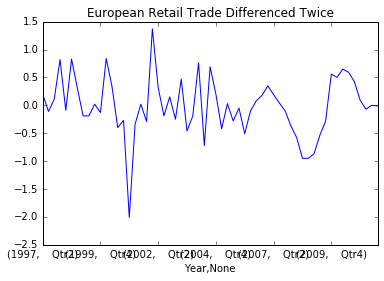

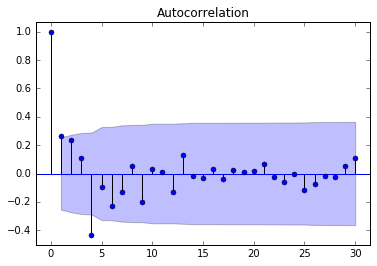

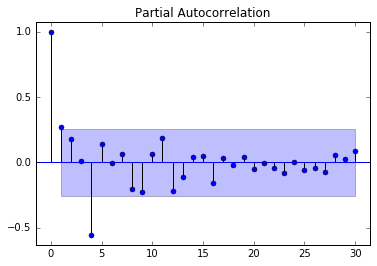

In [3]:

diff1 = diff0.diff()[1:]
diff1.plot(title='European Retail Trade Differenced Twice')
plot_acf(diff1, lags=30)
plot_pacf(diff1, lags=30)


Now we have stationary data, and have a good idea of which values for _d_ and _D_ we want for our model.

<a name="model"></a>
## Codealong: European Retail Trade Data Modeling (15 mins)

The next step is to find appropriate AR, MA, Seasonal AR, and Seasonal MA terms for our model. We will do this using the ACF and PACF of the doubly difference data. Our ACF shows a significant spike at lags 1 and 4. The first spike suggests a _non-seasonal_ MA(1) component, while the second spike suggests a _seasonal_ MA(1) component. 

Therefore, we will start with an **ARIMA(0,1,1)(0,1,1)4** model.

**CHECK:** Make sure you understand the reasoning behind the choices made to populate all of the Seasonal ARIMA parameters. Can you explain each to the person sitting next to you?

In [4]:
import statsmodels.api as sm
data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
print results.summary()

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Wed, 24 Aug 2016   AIC                             75.360
Time:                                   06:25:21   BIC                             81.837
Sample:                                        0   HQIC                            77.912
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.869      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.241

Take a moment to inspect the results summary before plotting the residuals. As we've only auditioned one model, the summary won't tell us much, but what do you see? Let's go ahead and plot the residuals and their ACF/PACF.

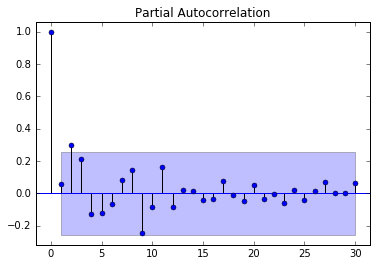

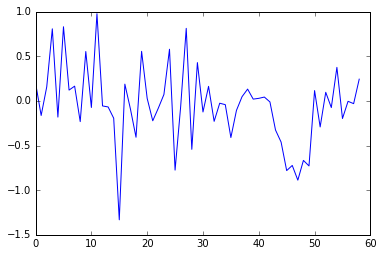

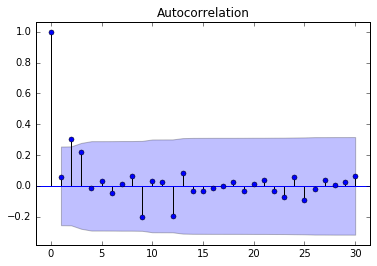

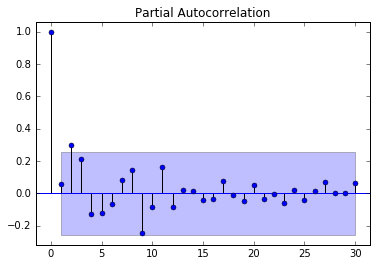

In [6]:
import matplotlib.pyplot as plt

# Don't plot the first 5 values, to account for data loss when differencing (d=1 + D=5)
residuals = results.resid[5:]
plt.plot(residuals)

plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)

What do we see? There are significant spikes at lag 2 in both ACF and PACF, and an almost significant spike at lag 3. This indiactes that some _additional_ non-seasonal terms are needed. 


<a name="intro-box"></a>
## Introduction: The Ljung-Box Test (10 Mins)

The Ljung-Box test is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. Instead of testing randomness at each distinct lag, it tests the “overall” randomness based on a number of lags. We can use this heuristic to test the fit of our model. By using the Ljung-Box test, we can determine whether the residuals from our model have any autocorrelation.

It is computed as such:

![](./assets/images/box.png)


Statsmodels leaves it up to the user to select the number of lags. For time series that are Non-Seasonal, it is recommended that you use _k_ = MIN(10, T/5). In other words, if your sample has over 50 observations, then your _k_ should be the number of periods divided by 5. Otherwise, use _k_ = 10.

Let's evaluate the output of the Ljung-Box test by checking the p-values, which are the second results provided. If the p-value is high, we will accept the Null Hypothesis that our data is Random.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = min(10, len(residuals)/5)

acorr_ljungbox(residuals, lags=lags)

What does the output tell us?

> Answer: The p-value of 0.22 at lag _k_ = 11 tells us that the residuals have no autocorrelations and are seemingly random


<a name="practice"></a>
## Guided Practice: Seasonal ARIMA Tuning (25 mins)

We're going to tune this further. On your own, or with a partner, start auditioning more SARIMA models on our data. Open the [`sarima.ipynb`](./starter-code/sarima.ipynb) notebook to get started.

Some tips along the way:

- Record your AIC values for each SARIMA model
- Examine the ACF/PACF of your residuals. Do they resemble white noise?
- For each model you try, add a comment as to the effect you think your tuning had
- Try only altering one term at a time

Let's go ahead and review the models. Who found the lowest AIC? Let's discuss how you got there, and what you've learned.


<a name="predictions"></a>
## Codealong: Predictions (10 mins)

Now that we've chosen a model, let's chart our predictions. We can use the built in `forecast` function to make this easy. Let's go over a quick way to view our forecast.

In [ ]:

preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');


**CHECK:** Do these predictions look meaningful based on the data? How do the predictions compare to the Non-Seasonal ARIMA model?

<a name="conclusion"></a>
## Conclusion (10 mins)
* These models typically take months to tune. 
    * We are not expecting you to leave with a working knowledge of ARIMA/SARIMA models, but insights into the kind of work we do as Data Scientists.

***

### ADDITIONAL RESOURCES

- [Penn State STAT 510 SARIMA Lesson](https://onlinecourses.science.psu.edu/stat510/node/67)
- [Duke SARIMA Lesson](http://people.duke.edu/~rnau/seasarim.htm)
- [SARIMAX Documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)